# 逻辑回归（Logistic Regression）与随机梯度下降（SGD）

> 纯Python从零实现逻辑回归和梯度下降

我们将建立一个逻辑回归模型来预测一个学生是否被大学录取。假设你是一个大学系的管理员，你想根据两次考试的结果来决定每个申请人的录取机会。你有以前的申请人的历史数据，你可以用它作为逻辑回归的训练集。对于每一个培训例子，你有两个考试的申请人的分数和录取决定。为了做到这一点，我们将建立一个分类模型，根据考试成绩估计入学概率。

首先读取这个文件"LogiReg_data.txt"的数据前5行,看一下数据是长什么样子的,具体代码如下:(备注:Admitted是代表是否录取的意思)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#%将那些用matplotlib绘制的图显示在页面里而不是弹出一个窗口
%matplotlib inline 

pdData=pd.read_csv("LogiReg_data.txt",header=None,names=['Exam 1', 'Exam 2', 'Admitted'])
print(pdData.head())

      Exam 1     Exam 2  Admitted
0  34.623660  78.024693         0
1  30.286711  43.894998         0
2  35.847409  72.902198         0
3  60.182599  86.308552         1
4  79.032736  75.344376         1


对数据有个大致的了解之后,求出这个数据的维度,如下:

In [2]:
print(pdData.shape)

(100, 3)


分别用0,1表示正例和负例.'Exam 1'以及'Exam 2'分别录取的人数的散点图

Text(0, 0.5, 'Exam 2 Score')

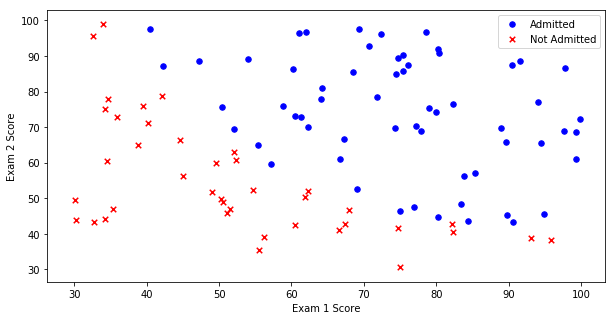

In [3]:
positive=pdData[pdData["Admitted"]==1]
negative=pdData[pdData["Admitted"]==0]
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=30, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

蓝色的点代表是录取的,未被录取的是红色的.对两种颜色的点是否可以进画一条决策边界呢?

数据现在也有了,算法之前也推倒过了,怎么用python将逻辑回归实现出来?

## 首先要了解一下逻辑回归:
目标：建立分类器（求解出三个参数 $θ_0$、$θ_1$、$θ_2$ ）

>备注：$θ_1$对应'Exam 1'成绩,$θ_2$对应'Exam 2'

设定阈值，根据阈值判断录取结果

>备注：阈值指的是最终得到的概率值.将概率值转化成一个类别.一般是＞0.5是被录取了,＜0.5未被录取.

要完成的模块：

- sigmoid : 映射到概率的函数
- model : 返回预测结果值
- cost : 根据参数计算损失
- gradient : 计算每个参数的梯度方向
- descent : 进行参数更新
- accuracy: 计算精度

sigmoid 函数：

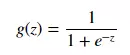

- g:ℝ→[0,1] (值域是0到1)
- g(0)=0.5 (当x=0时,y=0.5)
- g(−∞)=0 (当x趋于负无穷时,y=0)
- g(+∞)=1 (当x趋于正无穷时,y=1)

如果不知道sigmoid 函数长什么样子,可以看看如下的案例代码

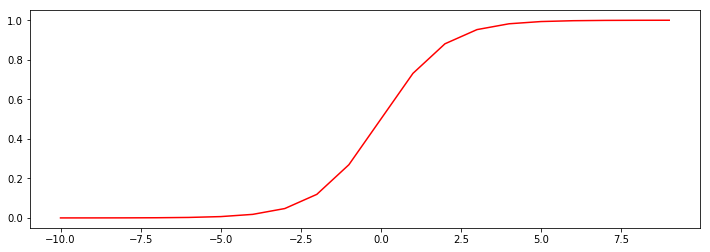

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

nums=np.arange(-10,10,step=1)
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(nums,sigmoid(nums),"r")

当构造一个回归模型的时候,要把数据当中插入一列,让那一列的值都等于1.要把数值计算转化成矩阵的运算.根据理论让代码实现出来,

备注:

### 知识点1:
- np.dot()这个是矩阵的乘法,然后将数据传入到sigmoid(z),相当于以下截图的过程.

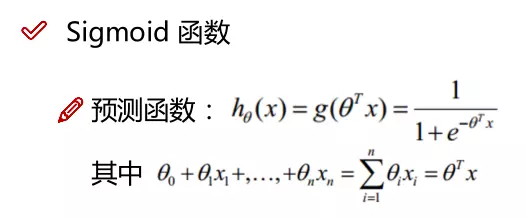

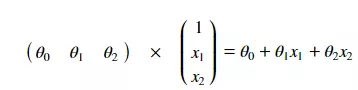


### 知识点2:
pdData.insert(0, 'Ones', 1)

具体用法如下:
> ` numpy.insert(arr,obj,value,axis=None)`
- arr:为插入目标列的位置
- obj:插入为目标列的名称
- value:为想要插入列的数值
- axis:为插入的维度
例如:

In [5]:
pdData.insert(0, 'Ones', 1)
print(pdData.head())

   Ones     Exam 1     Exam 2  Admitted
0     1  34.623660  78.024693         0
1     1  30.286711  43.894998         0
2     1  35.847409  72.902198         0
3     1  60.182599  86.308552         1
4     1  79.032736  75.344376         1


### 知识点3:
将frame转换为其Numpy数组表示。

`pd.as_matrix()`

建立一个4*2的矩阵，利用shape可输出矩阵的维度，即行数和列数。shape[0]和shape[1]分别代表多少行和多少列

In [6]:
orig_data=pdData.as_matrix()

/Users/kang/.conda/envs/d2_project/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### 知识点4:
theta是当前的一个参数,虽然参数没有一个具体的值,但是也需要给参数进行占位.

通常情况下,指定一个结构的时候,虽然里面的值我们不关心,但是必须有这样的位置给它创建出来.

一般用0进行填充,比如这里用到了`theta=np.zeros([1,3])`,创建了1行3列填充数据为0的矩阵.相当于构造了3个θ0、θ1、θ2参数.

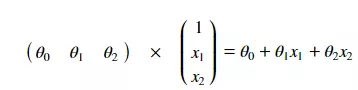


In [7]:
cols=orig_data.shape[1]
x=orig_data[:,0:cols-1]#1-倒数第1列的数据
y=orig_data[:,cols-1:cols]#倒数第1列的数据
theta=np.zeros([1,3])#1行三列的矩阵全部填充为0
print(x[:5])

[[ 1.         34.62365962 78.02469282]
 [ 1.         30.28671077 43.89499752]
 [ 1.         35.84740877 72.90219803]
 [ 1.         60.18259939 86.3085521 ]
 [ 1.         79.03273605 75.34437644]]


再看看y

In [8]:
print(y[:5])

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]]


看看theta

In [9]:
print(theta)

[[0. 0. 0.]]


接下来对数据进行组合,并得到最终的结果.

首先先定义损失函数:

将对数似然函数去负号


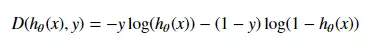

求平均损失

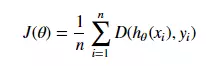

这个损失函数是怎么来的,是根据以下截图的应用梯度上升最大值得来的:($-\frac 1 n$的过程分步骤,先对数似然函数去负号,再除以$n$)

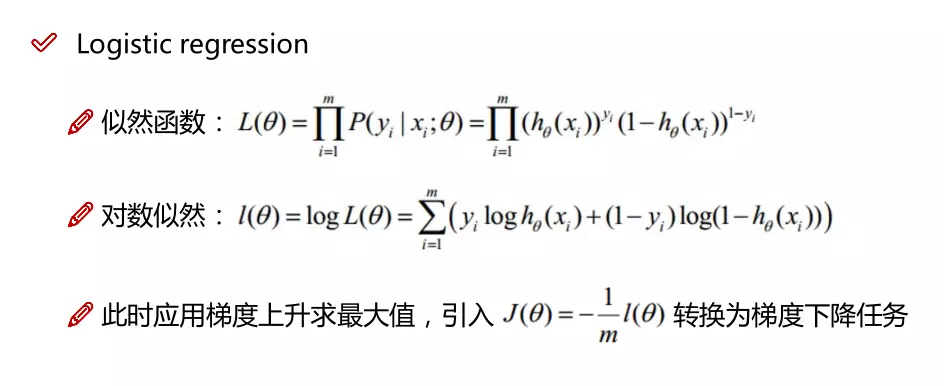

这个函数用python代码怎么表达cost()这个损失函数呢?并计算这个损失函数?

In [10]:
import numpy as np
import pandas as pd 
pdData=pd.read_csv("LogiReg_data.txt",header=None,names=['Exam 1', 'Exam 2', 'Admitted'])
def sigmoid(z):
    return 1/(1+np.exp(-z))

def model(X,theta):
    return sigmoid(np.dot(X,theta.T))

def cost(x,y,theta):
    left=np.multiply(-y,np.log(model(x,theta)))
    right=np.multiply(1-y,np.log(1-model(x,theta)))
    return np.sum(left-right)/(len(x))

pdData.insert(0, 'Ones', 1)
orig_data=pdData.as_matrix()
cols=orig_data.shape[1]
x=orig_data[:,0:cols-1]#1-倒数第1列的数据
y=orig_data[:,cols-1:cols]#倒数第1列的数据
theta=np.zeros([1,3])#1行三列的矩阵全部填充为0
print(cost(x,y,theta))

0.6931471805599453


/Users/kang/.conda/envs/d2_project/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


以上我们完成了LR部分的代码建模，可以看到代码很简单

## 下面我们看下梯度下降部分怎么实现

接下来,怎么计算梯度函数?

梯度函数是以下截图

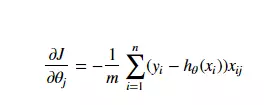
就是求偏导,求导的过程就是以下截图的内容(略)

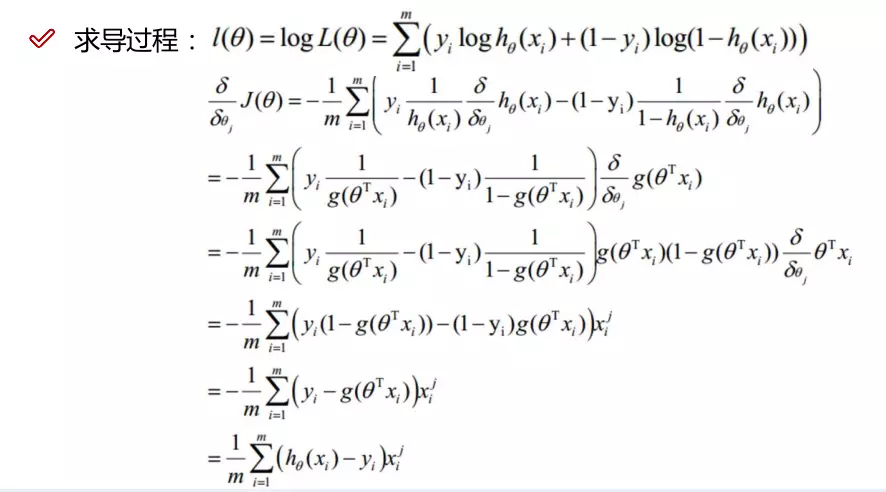

构造theta参数的时候,构造的是3个参数$θ_0$、$θ_1$、$θ_2$参数, 那这三个参数求解的时候,应该求出几个梯度呀?

显然也是三个.具体相关知识点如下:

1. 在python代码中,定义grad为梯度,用`np.zeros(theta.shape)`中的zeros函数进行占位.梯度应与`theta.shape`的维度是一致的.
2. 这里的`error=yi−hθ(xi)`,跟表达式有点相反了,原因是把负号提到里面去了.
3. `np.ravel()`将多维数组降为一维,返回的是视图，修改时会影响原始矩阵 .

案例代码如下:

In [11]:
a = np.array([[1 , 2] , [3 , 4]])
c=a.ravel()
print(c)

c[0]=10
print(c)

[1 2 3 4]
[10  2  3  4]


梯度函数怎么用python表达呢?
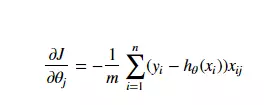

In [12]:
def gradient(x, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(x, theta)- y).ravel()
    for j in range(len(theta.ravel())): #for each parmeter
        term = np.multiply(error, x[:,j])
        grad[0, j] = np.sum(term) / len(x)
    
    return grad

比较3种不同梯度下降的方法,具体梯度下降的方法如下截图:
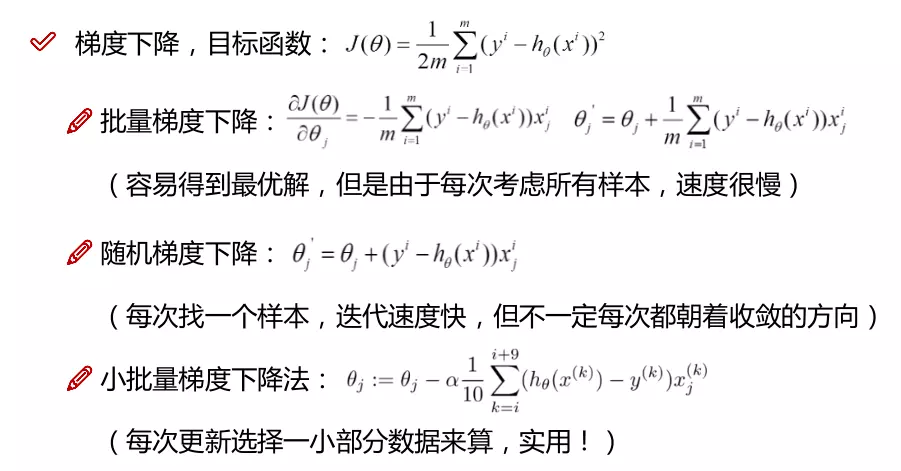

### 训练停止策略
#### 第一种策略
是按照迭代次数进行停止,因为进行模型优化的时候,可以进行迭代,在不断进行迭代的过程中,无论是多少次,最终都需要停下来.这里就设置了3种停止的策略.

比如设置迭代次数是2000次,一旦达到次数,每次进行优化,每次进行参数更新,就进行计数.迭代次数跟什么挂钩呢?就是更新一次参数就是完成了一次迭代.再更新一次参数,就是再完成了一次迭代.根据迭代次数,指定成一个值,达到了这样的一个值,就完成了更新.

#### 第二种策略
是看一下损失函数的目标函数的变化,在迭代的过程中,可以知道迭代之前的目标函数,迭代完之后的目标函数,如果这两个目标函数差异非常小,几乎没有变化,迭代就可以停止下来.

#### 第三种策略
根据梯度,如果前后两次迭代梯度的值差不多,几乎没啥变化,那么迭代也是可以停止下来的.

以上就是三种不同的梯度下降方法,不同的方法进行比较,看一下这三种算法得到的结果怎么样?不仅要看这三种停止策略,还要结合不同梯度下降,比如小批量的梯度下降/随机梯度下降/批量梯度下降.

首先定义一个函数,针对不同的三种停止策略,具体如下:

In [13]:
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    #设定三种不同的停止策略
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:      return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      return np.linalg.norm(value) < threshold

在做迭代更新的时候,首先对数据进行洗牌,洗牌是因为现在的数据看起来是有规律的,因为数据是我们自己进行收集的,收集的过程中可能按照某种顺序.比如身高排序,比如先收集男生的再收集女生的.

为了使模型的泛化能力更强,第一步先把数据进行打乱,做一个乱序的数据,通常把这种做法叫做洗牌,也叫shuffle操作,numpy有提供这样的操作.

通过numpy中的random模块,也就是随机模块,有shuffle函数,将数据传进去就可以进行洗牌.洗牌之后,把数据重新的指定好,然后再重新指定对应的x,y.

In [14]:
import numpy.random
#洗牌
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    x = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return x, y

之前有说过,不同梯度下降,所消耗的时间也是不一样的.这里还要看一下时间对结果的影响.这里通过定义descent函数进行.

- data这里指的是数据; theta这里指的是参数; 
- batchSize指定成1,那就是随机梯度下降；指定成总的样本数,那就是批量梯度下降；指定正1到总体之间,那就是小批量梯度下降；
- thresh指的是策略对应的阈值；alpha指的是学习率.
- 首先初始化值,i = 0第一次迭代,k = 0第0次batch. `x, y = shuffleData(data)`对xy进行洗牌.
- `grad = gradient(x[k:k+batchSize], y[k:k+batchSize], theta)`因为有三种不同的梯度下降的方法,每种方法对应数据的个数是不一样的.这里按实际传进来的数据进行计算.
- `theta = theta - alpha*grad`参数更新的过程.
- `costs.append(cost(x, y, theta))`将每一次迭代的损失都画出来.

按什么样的方式进行停止策略.如果到了停止的策略,则就跳出循环,直接返回一个新的结果值,就可以了.

In [15]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    #梯度下降求解
    
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    x, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(x, y, theta)] # 损失值

    while True:
        grad = gradient(x[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            x, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(x, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

为了使画图的时候知道当前迭代多少次,以及停止策略以及batch的一个结果,就定义了一个功能性的一个函数runExpe().

- `theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)`先对一个值进行初始化,然后进行求解.这是核心代码.

- 选择梯度下降的方式以及停止策略

> 这一部分是怎么在图上显示它的名字.是根据传进来的参数,比如是批量梯度下降or随机梯度下降or小批量梯度下降的参数.
>
> 以下代码时初始化,根据选择传进来的参数,如果数据传进来一个,则是随机梯度下降方式,
>
> 如果传进来的是总体则是批量梯度下降;
>
> 如果传进来的是小批量的数据则是小批量梯度下降.

In [16]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    
    # 拼接字符串：梯度下降方式
    if batchSize==n: 
        strDescType = "Gradient"
    elif batchSize==1:  
        strDescType = "Stochastic"
    else: 
        strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    
    # 拼接字符串：停止策略
    if stopType == STOP_ITER: 
        strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: 
        strStop = "costs change < {}".format(thresh)
    else: 
        strStop = "gradient norm < {}".format(thresh)
    name += strStop
    
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

当n值指定为100的时候,相当于整体对于梯度下降,为什么呢?因为我的数据样本就100个.

传进来的数据是按照迭代次数进行停止的,指定迭代次数的参数是thresh=5000.学习率是alpha=0.000001.

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 1.15s


array([[-0.00027127,  0.00705232,  0.00376711]])

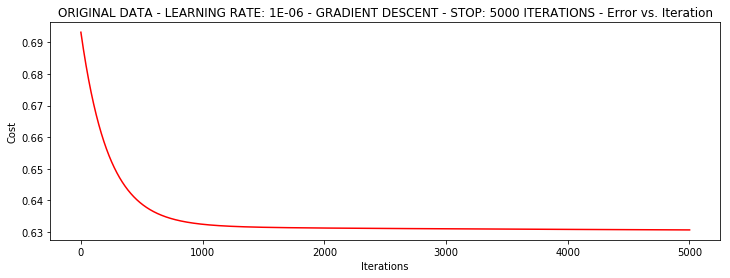

In [17]:
n=100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

x轴是我的迭代次数,y轴是我们的目标函数,随着迭代,目标函数进行一个收敛.5000次之后最终得到一个结果.共用了0.18s,完成了一个整体的迭代,速度还是比较快的,因为数据量比较小.

完整的代码如下:

/Users/kang/.conda/envs/d2_project/lib/python3.6/site-packages/ipykernel_launcher.py:94: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[0.00515976 0.00515976 0.00515976]] - Iter: 5000 - Last cost: 0.63 - Duration: 1.17s


array([[0.00515976, 0.00515976, 0.00515976]])

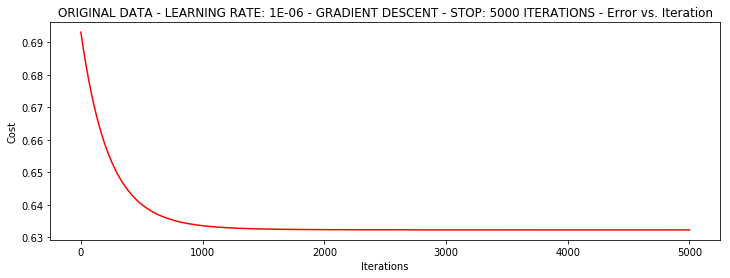

In [18]:
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt

pdData=pd.read_csv("LogiReg_data.txt",header=None,names=['Exam 1', 'Exam 2', 'Admitted'])

def sigmoid(z):
    return 1/(1+np.exp(-z))

def model(x,theta):
    return sigmoid(np.dot(x,theta.T))

def cost(x,y,theta):
    left=np.multiply(-y,np.log(model(x,theta)))
    right=np.multiply(1-y,np.log(1-model(x,theta)))
    return np.sum(left-right)/(len(x))

def gradient(x,y,theta):
    grad=np.zeros(theta.shape)
    error=(model(x,theta)-y).ravel()
    for j in range(len(theta.ravel())):
        term=np.multiply(error,x[:,j])
        grad[0,j]=np.sum(term)/len(x)
    return grad[0,j]

STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2
def stopCriterion(type, value, threshold):
    #设定三种不同的停止策略
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:      return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      return np.linalg.norm(value) < threshold

def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    x = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return x, y

def descent(data, theta, batchSize, stopType, thresh, alpha):
    #梯度下降求解
    
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    x, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(x, y, theta)] # 损失值

    while True:
        grad = gradient(x[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            x, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(x, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta


pdData.insert(0, 'Ones', 1)
orig_data=pdData.as_matrix()
cols=orig_data.shape[1]
x=orig_data[:,0:cols-1]#1-倒数第1列的数据
y=orig_data[:,cols-1:cols]#倒数第1列的数据
theta=np.zeros([1,3])#1行三列的矩阵全部填充为0
n=100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)


# 回顾

#### 逻辑回归
- sigmoid : 映射到概率的函数
- model : 返回预测结果值
- cost : 根据参数计算损失

#### 梯度下降
- gradient : 计算每个参数的梯度方向

#### 训练过程
- stop : 停止策略
- descent : 进行参数更新